In [6]:
%load_ext autoreload
%autoreload 2
import os, sys, json
print(os.getcwd())
os.environ['HF_HOME'] = '/home/jovyan/shares/SR003.nfs2/.cache/huggingface'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/shares/SR003.nfs2/kandi_video/vlad_test/RL


In [7]:
from torch import nn
import torch
from torch.nn import functional as F
import typing as tp
import pandas as pd
import datasets
from transformers import PreTrainedTokenizerFast, get_scheduler
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import wandb
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Наша игрушечная модель:

In [9]:
class ReluModel(nn.Module):
    def __init__(self, input_dim=10000, hidden_dim=2):
        super().__init__()
        self.W = nn.Parameter(torch.zeros(hidden_dim, input_dim))
        self.bias = nn.Parameter(torch.zeros(input_dim))
        nn.init.xavier_uniform_(self.W)
    
    def forward(self, x):
        h = torch.matmul(x, self.W.t()) 
        x_ = torch.relu(torch.matmul(h, self.W) + self.bias)
        return x_

In [33]:
def train_model(data, num_steps=50000, warmup_steps=2500, lr=1e-3, weight_decay=1e-2, hidden_dim=2):
    model = ReluModel(input_dim, hidden_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = get_scheduler('cosine', optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_steps)
    criterion = nn.MSELoss()
    losses = []
    for step in tqdm(range(num_steps), total=num_steps):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, data.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        if (step+1) % 10000 == 0:
            print(f"Step {step+1}/{num_steps}, Loss: {loss.item()}")
    return model, losses

In [21]:
T_grid = [200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
m_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16]

Используем все те же параметры, которые указаны для экспериментов.

In [22]:
input_dim = 10000
hidden_dim = 2
generator = torch.Generator(device='cpu').manual_seed(42)

In [ ]:
losses_dict = {}
for T in T_grid:
     for m in m_grid:
        data = torch.zeros(T, input_dim)
        mask = (torch.rand(T, input_dim) > 0.999)
        data[mask] = torch.rand(torch.sum(mask), generator=generator)
        data = data / data.norm()
        trained_relu_model, losses = train_model(data, hidden_dim=m)
        torch.save(trained_relu_model.state_dict(), f'toy_models/trained_relu_model_m{m}_T{T}.pth')
        print(f'Saved: trained_relu_model_m{m}_T{T}.pth')
        losses_dict[(T, m)] = losses 
        del trained_relu_model
        torch.cuda.empty_cache()
        gc.collect()

 20%|██        | 10020/50000 [00:47<03:19, 200.39it/s]

Step 10000/50000, Loss: 4.726886118078255e-07


 40%|████      | 20047/50000 [01:35<02:20, 213.04it/s]

Step 20000/50000, Loss: 4.6701001110704965e-07


 60%|██████    | 30034/50000 [02:23<01:33, 214.45it/s]

Step 30000/50000, Loss: 4.660641366172058e-07


 80%|████████  | 40033/50000 [03:09<00:35, 278.33it/s]

Step 40000/50000, Loss: 4.6575746637245174e-07


100%|██████████| 50000/50000 [03:53<00:00, 213.87it/s]


Step 50000/50000, Loss: 4.657138390484761e-07
Saved: trained_relu_model_m2_T200.pth


 20%|██        | 10027/50000 [00:48<03:19, 200.10it/s]

Step 10000/50000, Loss: 4.57384118135451e-07


 40%|████      | 20022/50000 [01:36<02:26, 204.69it/s]

Step 20000/50000, Loss: 4.5405758442029764e-07


 60%|██████    | 30034/50000 [02:24<01:39, 199.69it/s]

Step 30000/50000, Loss: 4.528723991370498e-07


 80%|████████  | 40026/50000 [03:12<00:48, 206.33it/s]

Step 40000/50000, Loss: 4.507101891704224e-07


100%|██████████| 50000/50000 [04:00<00:00, 207.63it/s]


Step 50000/50000, Loss: 4.499043200212327e-07
Saved: trained_relu_model_m3_T200.pth


 20%|██        | 10036/50000 [00:48<03:07, 213.30it/s]

Step 10000/50000, Loss: 4.17890987591818e-07


 40%|████      | 20035/50000 [01:31<02:26, 205.23it/s]

Step 20000/50000, Loss: 3.7677418163184484e-07


 60%|██████    | 30033/50000 [02:19<01:36, 207.70it/s]

Step 30000/50000, Loss: 3.755713464670407e-07


 80%|████████  | 40017/50000 [03:07<00:49, 201.29it/s]

Step 40000/50000, Loss: 3.7549293097072223e-07


100%|██████████| 50000/50000 [03:55<00:00, 212.07it/s]


Step 50000/50000, Loss: 3.754897193175566e-07
Saved: trained_relu_model_m4_T200.pth


 20%|██        | 10027/50000 [00:48<03:11, 209.05it/s]

Step 10000/50000, Loss: 3.7517233408834727e-07


 40%|████      | 20034/50000 [01:36<02:31, 197.53it/s]

Step 20000/50000, Loss: 3.498910530197463e-07


 60%|██████    | 30021/50000 [02:25<01:35, 209.58it/s]

Step 30000/50000, Loss: 3.4422765793351573e-07


 80%|████████  | 40038/50000 [03:13<00:42, 236.00it/s]

Step 40000/50000, Loss: 3.4407614180054225e-07


100%|██████████| 50000/50000 [03:57<00:00, 210.29it/s]


Step 50000/50000, Loss: 3.4407054272378446e-07
Saved: trained_relu_model_m5_T200.pth


 20%|██        | 10027/50000 [00:48<03:11, 208.74it/s]

Step 10000/50000, Loss: 3.0041874765629473e-07


 40%|████      | 20031/50000 [01:36<02:14, 223.44it/s]

Step 20000/50000, Loss: 2.549242879013036e-07


 60%|██████    | 30022/50000 [02:25<01:41, 196.22it/s]

Step 30000/50000, Loss: 2.546876771702955e-07


 80%|████████  | 40031/50000 [03:14<00:46, 214.91it/s]

Step 40000/50000, Loss: 2.546003656789253e-07


100%|██████████| 50000/50000 [04:03<00:00, 204.94it/s]


Step 50000/50000, Loss: 2.5459482344558637e-07
Saved: trained_relu_model_m6_T200.pth


 20%|██        | 10029/50000 [00:53<03:37, 184.07it/s]

Step 10000/50000, Loss: 1.9850796206810628e-07


 40%|████      | 20025/50000 [01:45<02:40, 187.11it/s]

Step 20000/50000, Loss: 1.9667461970129807e-07


 60%|██████    | 30025/50000 [02:39<01:48, 184.39it/s]

Step 30000/50000, Loss: 1.9597995049025485e-07


 80%|████████  | 40036/50000 [03:34<00:52, 188.49it/s]

Step 40000/50000, Loss: 1.9578459387048497e-07


100%|██████████| 50000/50000 [04:27<00:00, 186.72it/s]


Step 50000/50000, Loss: 1.9575941223592963e-07
Saved: trained_relu_model_m2_T500.pth


 20%|██        | 10036/50000 [00:54<03:36, 184.61it/s]

Step 10000/50000, Loss: 1.9812080154224532e-07


 40%|████      | 20035/50000 [01:48<02:45, 181.19it/s]

Step 20000/50000, Loss: 1.9566232367651537e-07


 45%|████▍     | 22338/50000 [02:01<02:28, 185.93it/s]

In [17]:
criterion = nn.MSELoss()

In [23]:
generator = torch.Generator(device='cpu').manual_seed(1)

In [24]:
losses_dict = {}
T_grid = [200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
m_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16]
for T in tqdm(T_grid):
     for m in m_grid:
        data = torch.zeros(T, input_dim)
        mask = (torch.rand(T, input_dim) > 0.999)
        data[mask] = torch.rand(torch.sum(mask), generator=generator)
        data = data / data.norm()
        trained_relu_model =  ReluModel(input_dim, m).to(device)
        trained_relu_model.load_state_dict(torch.load(f'toy_models/trained_relu_model_m{m}_T{T}.pth'))
        trained_relu_model.eval()
        outp = trained_relu_model(data.to(device))
        loss = criterion(outp, data.to(device))
        losses_dict[(m, T)] = loss.item()
        del trained_relu_model
        torch.cuda.empty_cache()
        gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_30953/1015442149.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_relu_model.load_state_dict(torch.load(f'toy

In [25]:
losses = np.zeros((8, 10))

In [26]:
for i, T in enumerate(T_grid):
     for j, m in enumerate(m_grid):
         losses[i, j] = losses_dict[(m, T)]

Ниже представлен график ошибок при разных значениях размера датасета T (от 200 до 50000) и размере хидена m (от 2 до 16).

Как можем заметить, наши результаты сходятся со статьей.

<Axes: >

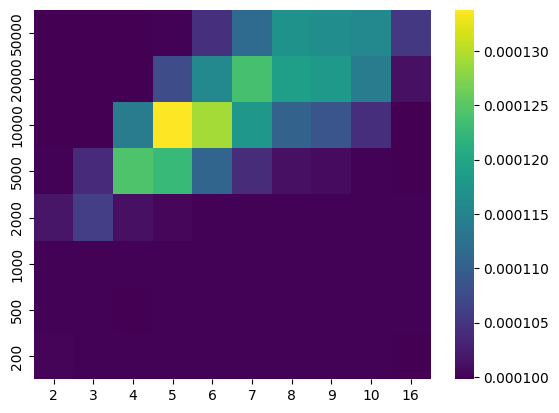

In [14]:
sns.heatmap(np.flip(losses, 0), xticklabels=m_grid, yticklabels=T_grid[::-1], cmap='viridis')

Перейдем к исследованию зависимости от weight decay. Будем использовать те же параметры, что и в статье.

In [36]:
input_dim = 10000
hidden_dim = 4
T_grid = [100, 1000, 5000, 10000, 50000]
generator = torch.Generator(device='cpu').manual_seed(228)

In [24]:
w_decays = [1e-4, 1e-2, 1]

In [ ]:
decay_losses_dict = {}
for T in T_grid:
     for w_dec in w_decays:
        data = torch.zeros(T, input_dim)
        mask = (torch.rand(T, input_dim) > 0.999)
        data[mask] = torch.rand(torch.sum(mask), generator=generator)
        data = data / data.norm()
        trained_model, losses = train_model(data, weight_decay=w_dec, hidden_dim=hidden_dim)
        torch.save(trained_model.state_dict(), f'toy_models/decay_trained_relu_model_d{w_dec}_T{T}.pth')
        print(f'Saved: decay_trained_relu_model_d{w_dec}_T{T}.pth')
        decay_losses_dict[(T, w_dec)] = losses 
        pd.to_pickle(decay_losses_dict, 'decay_losses_dict.pkl')
        del trained_model
        torch.cuda.empty_cache()
        gc.collect()

 20%|██        | 10036/50000 [00:46<02:58, 223.46it/s]

Step 10000/50000, Loss: 6.07023025622766e-07


 40%|████      | 20033/50000 [01:32<02:19, 214.67it/s]

Step 20000/50000, Loss: 6.062130637474183e-07


 60%|██████    | 30020/50000 [02:19<01:34, 211.42it/s]

Step 30000/50000, Loss: 5.91250113757269e-07


 80%|████████  | 40018/50000 [03:05<00:46, 214.80it/s]

Step 40000/50000, Loss: 5.899460120417643e-07


100%|██████████| 50000/50000 [03:52<00:00, 215.36it/s]


Step 50000/50000, Loss: 5.886192298021342e-07
Saved: decay_trained_relu_model_d0.0001_T100.pth


  9%|▉         | 4468/50000 [00:19<03:15, 233.19it/s]

In [45]:
decay_losses_dict_test = {}
for T in tqdm(T_grid):
     for w_dec in w_decays:
        data = torch.zeros(T, input_dim)
        mask = (torch.rand(T, input_dim) > 0.999)
        data[mask] = torch.rand(torch.sum(mask), generator=generator)
        data = data / data.norm()
        trained_relu_model =  ReluModel(input_dim, hidden_dim=hidden_dim).to(device)
        trained_relu_model.load_state_dict(torch.load(f'toy_models/decay_trained_relu_model_d{w_dec}_T{T}.pth'))
        trained_relu_model.eval()
        outp = trained_relu_model(data.to(device))
        loss = criterion(outp, data.to(device))
        decay_losses_dict_test[(T, w_dec)] = loss.item()
        del trained_relu_model
        torch.cuda.empty_cache()
        gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_114/142005600.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_relu_model.load_state_dict(torch.load(f'toy_mod

In [39]:
train_loss = dict(map(lambda x: (x[0], np.mean(x[1])), decay_losses_dict.items()))

In [42]:
train_loss_dict = {}
for w_dec in w_decays:
    train_loss_dict[w_dec] = []
    for T in T_grid:
        train_loss_dict[w_dec].append(train_loss[(T, w_dec)])

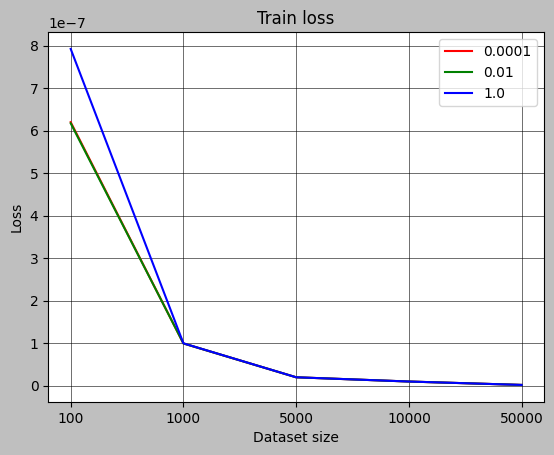

In [44]:
with plt.style.context('grayscale'):
    plt.grid(linewidth=0.4)
    plt.plot(list(range(5)), train_loss_dict[0.0001], 'r-', markersize=8, label='0.0001')
    plt.plot(list(range(5)), train_loss_dict[0.01], 'g-', markersize=8, label='0.01')
    plt.plot(list(range(5)), train_loss_dict[1], 'b-', markersize=8, label='1.0')
    plt.title('Train loss')
    plt.xlabel('Dataset size')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(ticks=list(range(5)),labels=T_grid)
    plt.savefig('train_loss_decay.png')
    plt.show()

In [47]:
test_loss_dict = {}
for w_dec in w_decays:
    test_loss_dict[w_dec] = []
    for T in T_grid:
        test_loss_dict[w_dec].append(decay_losses_dict_test[(T, w_dec)])

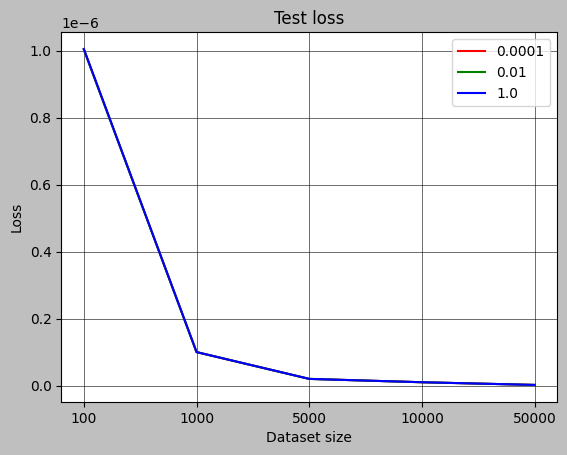

In [48]:
with plt.style.context('grayscale'):
    plt.grid(linewidth=0.4)
    plt.plot(list(range(5)), test_loss_dict[0.0001], 'r-', markersize=8, label='0.0001')
    plt.plot(list(range(5)), test_loss_dict[0.01], 'g-', markersize=8, label='0.01')
    plt.plot(list(range(5)), test_loss_dict[1], 'b-', markersize=8, label='1.0')
    plt.title('Test loss')
    plt.xlabel('Dataset size')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(ticks=list(range(5)),labels=T_grid)
    plt.savefig('test_loss_decay.png')
    plt.show()